<a href="https://colab.research.google.com/github/shayanshafquat/DeepLearning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd  /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
# import tensorflow_addons as tfa #extra addons
import tensorflow_hub as hub
import os
import seaborn as sns
import random

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
(train_ds, validation_ds, test_ds), metadata = tfds.load('cats_vs_dogs',
split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
with_info=True,
as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteIIQGRO/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [8]:
metadata

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpavzn14jqtfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    

In [7]:
# Print the shape of the first element of each dataset
for ds in [train_ds, validation_ds, test_ds]:
  for image, label in ds.take(1):
      print(image.shape, label)

(262, 350, 3) tf.Tensor(1, shape=(), dtype=int64)
(176, 168, 3) tf.Tensor(1, shape=(), dtype=int64)
(500, 377, 3) tf.Tensor(0, shape=(), dtype=int64)


image shape:  (262, 350, 3)
label: 1
image shape:  (409, 336, 3)
label: 1
image shape:  (493, 500, 3)
label: 1
image shape:  (375, 500, 3)
label: 0
image shape:  (240, 320, 3)
label: 1


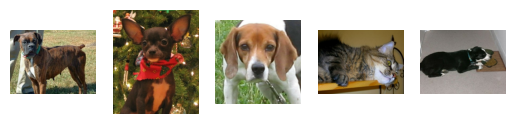

In [8]:
dataset = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
).take(5
)

f, axarr = plt.subplots(1,5)

i = 0
for image, label in dataset:
  print('image shape: ', np.shape(image));
  tf.print('label:',label);
  axarr[i].imshow(image);
  axarr[i].axis('off');
  i=i+1

Augmentation: Resizing the images

In [11]:
train = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
).cache( #cache images
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [200,200]),label)
).map( # random horizontal flip
      lambda image, label: (tf.image.random_flip_left_right(image), label)
).take(5
)

image shape:  (200, 200, 3)
label: 1
image shape:  (200, 200, 3)
label: 1
image shape:  (200, 200, 3)
label: 1
image shape:  (200, 200, 3)
label: 0
image shape:  (200, 200, 3)
label: 1


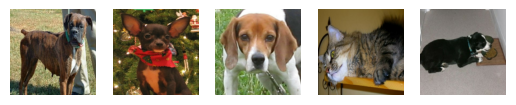

In [12]:
f, axarr = plt.subplots(1,5)

i = 0
for image, label in train:
  print('image shape: ', np.shape(image));
  tf.print('label:',label);
  axarr[i].imshow(image);
  axarr[i].axis('off');
  i=i+1

In [17]:
train = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
).cache( #cache images
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [224,224]),label)
).map( # random horizontal flip
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).shuffle(100
).batch(24
).take(1)

valid = validation_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
).map(
    lambda image, label: (tf.image.resize(image, [224, 224]), label)
).shuffle(100
).batch(24
).take(1)

test = test_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
).map(
    lambda image, label: (tf.image.resize(image, [224,224]), label)
).batch(100
).take(1)

Getting the model

We will use a pre-trained model. We will be using MobileNetV2_1.0_224.

This model is mobilenet version 2 with a depth multiplier of 1.0 trained on 224x224 images. This version has much fewer parameters than mobilenetV1. The model can be loaded as a keras layer. Lets read in the network and see what variables it contains and how many of them

In [19]:
mbnet = tf.keras.applications.MobileNetV2(include_top=False, weights=None) #read in network without top layer or weights

nvar =  len(mbnet.trainable_variables)
print('number of variables: ', nvar)
for i in np.arange(nvar):
  print(mbnet.trainable_variables[i].name) #variables name name
  print(mbnet.trainable_variables[i].shape) #kernel shape

number of variables:  156
Conv1/kernel:0
(3, 3, 3, 32)
bn_Conv1/gamma:0
(32,)
bn_Conv1/beta:0
(32,)
expanded_conv_depthwise/depthwise_kernel:0
(3, 3, 32, 1)
expanded_conv_depthwise_BN/gamma:0
(32,)
expanded_conv_depthwise_BN/beta:0
(32,)
expanded_conv_project/kernel:0
(1, 1, 32, 16)
expanded_conv_project_BN/gamma:0
(16,)
expanded_conv_project_BN/beta:0
(16,)
block_1_expand/kernel:0
(1, 1, 16, 96)
block_1_expand_BN/gamma:0
(96,)
block_1_expand_BN/beta:0
(96,)
block_1_depthwise/depthwise_kernel:0
(3, 3, 96, 1)
block_1_depthwise_BN/gamma:0
(96,)
block_1_depthwise_BN/beta:0
(96,)
block_1_project/kernel:0
(1, 1, 96, 24)
block_1_project_BN/gamma:0
(24,)
block_1_project_BN/beta:0
(24,)
block_2_expand/kernel:0
(1, 1, 24, 144)
block_2_expand_BN/gamma:0
(144,)
block_2_expand_BN/beta:0
(144,)
block_2_depthwise/depthwise_kernel:0
(3, 3, 144, 1)
block_2_depthwise_BN/gamma:0
(144,)
block_2_depthwise_BN/beta:0
(144,)
block_2_project/kernel:0
(1, 1, 144, 24)
block_2_project_BN/gamma:0
(24,)
block_2_pr

In [21]:
mbnet.summary()

Model: "mobilenetv2_1.00_None"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1

In [22]:
tf.keras.backend.clear_session() #Clear keras session

Training from scratch

In [24]:
dropoutrate = 0.2
num_classes = 2
input_shape = [224, 224, 3]

mbnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights=None)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build()

model.summary() # print the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [25]:
with tf.GradientTape() as tape:
  tape.reset() #this resets the gradient tape

In [26]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) ) #update gradients of all layers
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [31]:
niter = 100

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label, depth=2) ) #run training

    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 == 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label, depth=2), val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label, depth=2), val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)

iter:  0 , loss: 0.686, acc: 0.583
iter:  0 , validation loss: 0.677, validation acc: 0.667
iter:  10 , loss: 0.708, acc: 0.333
iter:  20 , loss: 0.699, acc: 0.375
iter:  30 , loss: 0.690, acc: 0.583
iter:  40 , loss: 0.691, acc: 0.542
iter:  50 , loss: 0.695, acc: 0.458
iter:  50 , validation loss: 0.689, validation acc: 0.625
iter:  60 , loss: 0.692, acc: 0.583
iter:  70 , loss: 0.685, acc: 0.708
iter:  80 , loss: 0.704, acc: 0.375
iter:  90 , loss: 0.688, acc: 0.583


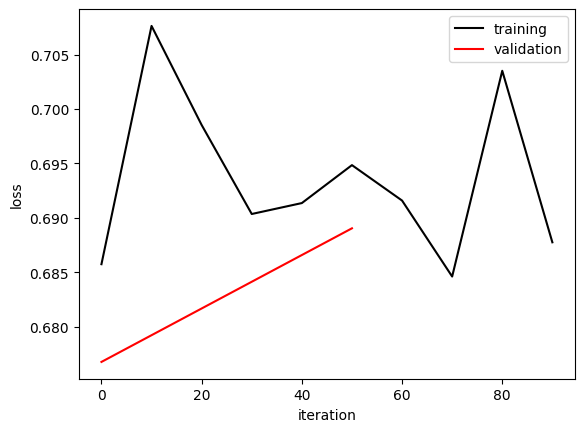

In [32]:
titers = 10*np.arange(np.shape(tloss)[0])
viters = 50*np.arange(np.shape(vloss)[0])

plt.plot(titers, tloss, c='black', label='training');
plt.plot(viters, vloss, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('loss');

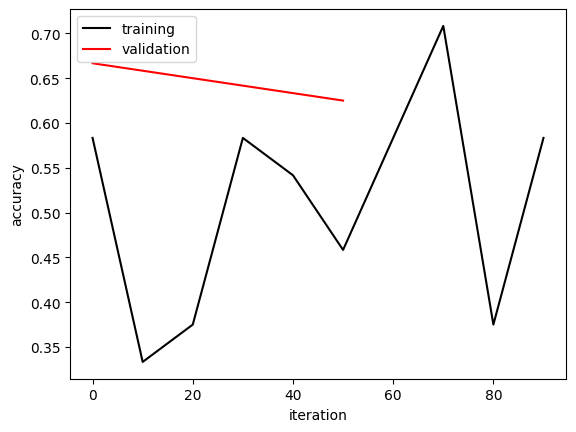

In [33]:
plt.plot(titers, tacc, c='black', label='training');
plt.plot(viters, vacc, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('accuracy');

## Transfer Learning

In [34]:
tf.keras.backend.clear_session() #Clear keras session

In [35]:
dropoutrate = 0.2
num_classes = 2
input_shape = [224, 224, 3]

mbnet =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
___________________

In [36]:
with tf.GradientTape() as tape:
  tape.reset() #this resets the gradient tape

In [37]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [39]:
niter = 1000

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label,depth=2) ) #run training

    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 == 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)

iter:  0 , loss: 0.705, acc: 0.500
iter:  0 , validation loss: 0.623, validation acc: 0.583
iter:  10 , loss: 0.171, acc: 0.958
iter:  20 , loss: 0.083, acc: 1.000
iter:  30 , loss: 0.022, acc: 1.000
iter:  40 , loss: 0.031, acc: 1.000
iter:  50 , loss: 0.014, acc: 1.000
iter:  50 , validation loss: 0.037, validation acc: 1.000
iter:  60 , loss: 0.010, acc: 1.000
iter:  70 , loss: 0.019, acc: 1.000
iter:  80 , loss: 0.006, acc: 1.000
iter:  90 , loss: 0.006, acc: 1.000
iter:  100 , loss: 0.006, acc: 1.000
iter:  100 , validation loss: 0.016, validation acc: 1.000
iter:  110 , loss: 0.012, acc: 1.000
iter:  120 , loss: 0.004, acc: 1.000
iter:  130 , loss: 0.004, acc: 1.000
iter:  140 , loss: 0.005, acc: 1.000
iter:  150 , loss: 0.005, acc: 1.000
iter:  150 , validation loss: 0.014, validation acc: 1.000
iter:  160 , loss: 0.004, acc: 1.000
iter:  170 , loss: 0.003, acc: 1.000
iter:  180 , loss: 0.006, acc: 1.000
iter:  190 , loss: 0.009, acc: 1.000
iter:  200 , loss: 0.006, acc: 1.000
i

KeyboardInterrupt: 

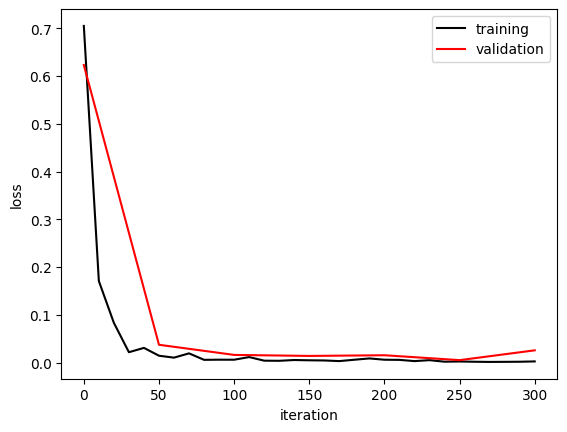

In [40]:
titers = 10*np.arange(np.shape(tloss)[0])
viters = 50*np.arange(np.shape(vloss)[0])

plt.plot(titers, tloss, c='black', label='training');
plt.plot(viters, vloss, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('loss');

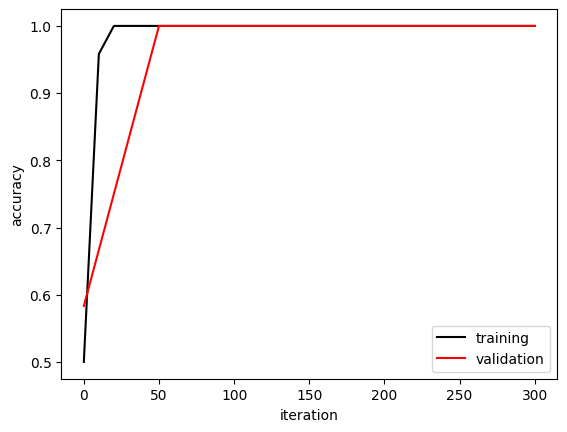

In [41]:
plt.plot(titers, tacc, c='black', label='training');
plt.plot(viters, vacc, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('accuracy');

## Save Weights

In [45]:
%cd Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [46]:
model.save_weights('mobileNetV2_weights.hdf5')

In [53]:
tf.keras.backend.clear_session() #Clear keras session

### Load Weights

In [54]:
dropoutrate = 0.2
num_classes = 2
input_shape = [224,224,3]

mbnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet') #We now dont want randomized weights but to load weights from imagenet

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [55]:
model.load_weights('mobileNetV2_weights.hdf5')

In [56]:
#unfreeze layers
mbnet.trainable = True # freeze the first layers to the imagenet weights
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


## Fine Tuning

In [57]:
LR = 0.00001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [ ]:
niter = 100

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label,depth=2) ) #run training

    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 == 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)

iter:  0 , loss: 0.003, acc: 1.000
iter:  0 , validation loss: 0.045, validation acc: 0.958
